# Langgraph

Framework to build iagen applications based on graphs with an explicit control and a very low degree of abstractions.  
It is complementary to langchain, that provides a lot of abstractions layers to switch over the underlying infrastructure  
Why Langgraph is needed over Langchain?  
Chains are a usefull tool, but it happens to be a little cumbersome in some aspects:
* No state definition
* Hard to code and debug a complex flow
* Developing and Agent does not fit well into chains

![agent](docs/agent-sutton-and-berto.png)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
from pathlib import Path
from dotenv import load_dotenv


from typing import TypedDict
from langgraph.graph import StateGraph

# Params

In [5]:
PARAMS1 = 1

# Environment Variables

In [6]:
load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]


 # Core primitives in LangGraph

* **State**
  A dictionary-like object (often a `TypedDict` or Pydantic model) that represents the app’s memory at any given time.

  * Keys = pieces of information (plan, result, messages, etc.)
  * Must be **mergeable** when multiple branches update it.

* **Nodes**
  Functions (sync or async) that take `state` as input and return updates to it.

  * Best practice: keep them deterministic and side-effect free.
  * Nodes are the “steps” of your workflow.
  * Can add information to the step by adding a key or can append data to a existing key, by defining a proper reducer function

* **Edges**
  The links between nodes, telling the graph where to go next.

  * **Deterministic edges**: always go from A → B.
  * **Conditional edges**: decide based on runtime state.
  * **Subgraphs**: reusable mini-graphs nested inside larger ones.

* **Channels**
  Mechanism for controlling which part of `state` a node can **read** or **write**. Prevents accidental overwrites.

* **Runners**
  How you actually *execute* the graph:

  * `invoke` → run synchronously on one input.
  * `batch` → run on many inputs at once.
  * `stream` → run synchronously and stream intermediate events.
  * `a- ` → run asynchronously


# Compilation vs Execution

* You **define** the graph (add nodes, edges, entry point).
* Then you call `.compile()` to check everything, freeze topology, and create an **App**.
* The App is what you actually **run** with `invoke`, `batch`, or `astream`.

Think of it like writing source code → compiling → running the binary. 

graph.compile() also validates the graph


## The State

It is usually a TypedDict or Pydantic data model (like dictionary) that allows to explicitly
set types over inputs, validation rules and so on


```python
class Person(TypedDict):
    name: str
    age: int

In [7]:
class Foo(TypedDict,
          total=False  # make keys optional
          ):
    a: int
    b: int


Foo(a=1, b=2)

{'a': 1, 'b': 2}

In [9]:
from pydantic import BaseModel

class Bar(BaseModel):
    a: int
    b: int


Bar(a=1, b=2)

Bar(a=1, b=2)

In [10]:
from pydantic_core import ValidationError
try:
    Bar(a=1)  # required field
except ValidationError as err:
    print(err)

1 validation error for Bar
b
  Field required [type=missing, input_value={'a': 1}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing


In [11]:
try:
    Bar(a=1, b="a")  # type mismatch
except ValidationError as err:
    print(err)

1 validation error for Bar
b
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='a', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/int_parsing


## Linear Graph

In [12]:
class State(TypedDict, total=False):
    plan: str
    result: str

def plan_node(state: State) -> dict:
    # Node returns only the keys it writes = safer "scoped writes"
    return {"plan": "Do X then Y"}

def act_node(state: State) -> dict:

    plan = state['plan']
    # f(x)
    result = f"Executed plan: {plan}"

    return {"result": result}

g = StateGraph(State)
g.add_node("plan", plan_node)
g.add_node("act", act_node)

g.set_entry_point("plan")
g.add_edge("plan", "act")            # deterministic edge

app = g.compile()

print("1) invoke:", app.invoke({}))
# -> {'plan': 'Do X then Y', 'result': 'Executed plan: Do X then Y'}


1) invoke: {'plan': 'Do X then Y', 'result': 'Executed plan: Do X then Y'}


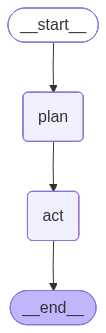

In [13]:
app

# Add an input

```python
class State(TypedDict, total=False):
    # ...  # add an input key
    plan: str
    result: str

def plan_node(state: State) -> dict:
    # get the input

    return {"plan": f"Do {} then Y"}   # place the input here

def act_node(state: State) -> dict:
    return {"result": f"Executed plan: {state['plan']}"}

g = StateGraph(State)
g.add_node("plan", plan_node)
g.add_node("act", act_node)

g.set_entry_point("plan")
g.add_edge("plan", "act") 

app = g.compile()

print("1) invoke:", app.invoke(
    {}  # modifiy this to pass input key
    )
)

In [11]:
# Excersice: Add an input

# Branching

**Scoped Reads/Writes (a pragmatic “channels” pattern)**

While LangGraph’s merge/reducer system keeps state safe, a simple discipline also helps:

* Read only what you need from state.
* Write only the keys you own (return a dict with just those keys)

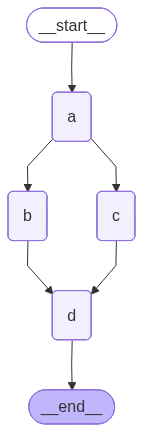

In [ ]:
# Exersice: complete

from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    input: str
    a: str
    b: str
    c: str
    out: str

# TODO

def a(state: State):
    # read input, count number of characters with len
    return {"a": ...}

def b(state: State):
    # read a, compute the square
    return {...: ...}

def c(state: State):
    # read a, compute the cube
    return {...: ...}

def d(state: State):
    # read b, and c and add them up, store in out

    return  {...: ...}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)


builder.add_edge(START, "a")   # g.set_entry_point("plan")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

graph

In [13]:
#graph.invoke({"input": "Hello!"})

# Conditional Edge

In [15]:
from langgraph.graph import END, START

class State(TypedDict, total=False):
    input_code: str
    plan: str
    result: str

def plan_node(state: State) -> dict:
    # IMPLEMENT ANY LOGING, TAKING DATA FROM STATE
    # AND RETURN A DICTIONARY WITH THE NEXT STEP
    if "Python" in state["input_code"]:
        return {"plan": "This code is Python"}
    else:
        return {"plan": "Do X then Y"}

def act_node(state: State) -> dict:
    return {"result": f"Executed plan: {state['plan']}"}

def should_review(state: State) -> bool:
    # Routing function: yield a set of stablished values and map them to any
    # desired step
    # Route to 'review' only if the plan contains 'Y'
    flg_should_review = "Y" in state["plan"] 
    return  flg_should_review

def review_node(state: State) -> dict:
    return {"result": state["result"] + " (reviewed)"}

g2 = StateGraph(State)
# Add nodes
g2.add_node("plan", plan_node)
g2.add_node("act", act_node)
g2.add_node("review", review_node)


# Link nodes
g2.set_entry_point("plan")
g2.add_edge("plan", "act")
g2.add_conditional_edges(
    "act",  # ORIGIN
    should_review,  # DECISION MAKING (Does not appear in plot)
    {True: "review", False: END}  # BRANCHES
    )
app2 = g2.compile()

print("2) conditional:", app2.invoke({"input_code": "Javascript"}))
print("2) conditional:", app2.invoke({"input_code": "Python"}))
# -> will include " (reviewed)" if condition is met, else stop at END


2) conditional: {'input_code': 'Javascript', 'plan': 'Do X then Y', 'result': 'Executed plan: Do X then Y (reviewed)'}
2) conditional: {'input_code': 'Python', 'plan': 'This code is Python', 'result': 'Executed plan: This code is Python'}


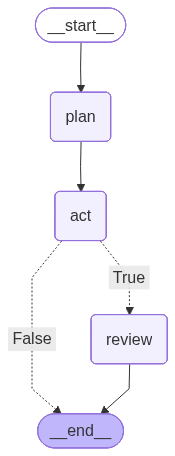

In [16]:
app2

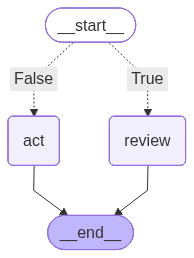

In [16]:
g3 = StateGraph(State)
# Add nodes
g3.add_node("act", act_node)
g3.add_node("review", review_node)


# Link nodes
g3.add_conditional_edges(START, should_review, {True: "review", False: "act"})
g3.add_edge("review", END)
g3.add_edge("act", END)

app3 = g3.compile()
app3


In [ ]:
# Exersice: complete

from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    input: str
    a: str
    b: str
    c: str
    out: str

def a(state: State):
    # read input, count number of characters with len
    return {"a": ...}

def b(state: State):
    # b="left" -> a<5
    # b="mid" -> a<10
    # b="right" -> a<100
    return {...: ...}

def c(state: State):
    # from b="left"
    # out = "X"
    return {...: ...}

def d(state: State):
    # from b="mid"
    # out = "Y"

    return  {...: ...}

def e(state: State):
    # from b="right"
    # out = "Z"

    return  {...: ...}

builder = StateGraph(State)
# TODO


# State merging

When in the State there is a key that is a list (or any other sequence), we may want to append objects to it  
In addition, we may want to update any State key that is not a list with a given logic defined in a convergent flow  
If two branches in the graph both return updates to `state`, LangGraph merges them:  
* Default: **last write wins**.
* Better: define **reducers** to specify how values combine (e.g., append messages, keep shortest string, sum scores).
  This makes concurrent flows safe.


In [17]:
class ChatState(TypedDict, total=False):
    messages: list 

def branch_a(state: ChatState) -> dict:
    return {"messages": [{"role": "system", "content": "branch A did work"}]}

def branch_b(state: ChatState) -> dict:
    return {"messages": [{"role": "system", "content": "branch B did work"}]}

g4 = StateGraph(ChatState)  # can be any pydantic
g4.add_node("a", branch_a)
g4.add_node("b", branch_b)

g4.set_entry_point("a") 
g4.add_edge("a", "b") 
g4.add_edge("b", END)


app4 = g4.compile()
out4 = app4.invoke({})

# B Overwrites messages
print("4) merged messages:", [m["content"] for m in out4["messages"]])


4) merged messages: ['branch B did work']


In [18]:
# Desired outcome:
# b appends to a

class ChatState(TypedDict, total=False):
    messages: list 

def branch_a(state: ChatState) -> dict:
    return {"messages": [{"role": "system", "content": "branch A did work"}]}

def branch_b(state: ChatState) -> dict:
    # whe know that this node executes after and overwrites the wkey messages
    # 1. Retrieve current key
    messages = state["messages"]  # List[{role: ... content: ...}]
    # 2. New data
    messages_new = {"role": "system", "content": "branch B did work"}
    # 3. Implement an append logic
    messages_upd = messages + [messages_new]

    return {"messages": messages_upd}

g4 = StateGraph(ChatState)  # can be any pydantic
g4.add_node("a", branch_a)
g4.add_node("b", branch_b)

g4.set_entry_point("a") 
g4.add_edge("a", "b") 
g4.add_edge("b", END)


app4 = g4.compile()
out4 = app4.invoke({})

# B Overwrites messages
print("4) merged messages:", [m["content"] for m in out4["messages"]])

4) merged messages: ['branch A did work', 'branch B did work']


### State update with reducing

![reduce](docs/reduce.png)

In [28]:
# Reduce function (In general)
from functools import reduce

reduce(lambda x, y: x + y, [1,2,3,4 ])

10

In [30]:
reduce(lambda x, y: x + "-" + y, ["1", "2" ,"3"])  

'1-2-3'

In [21]:
# Create your own reducer
def reducer(a: list, b: int | str | None) -> list:
    if b is not None:
        return a + [b]
    return a

reducer(
    ["Hello"], "World"
)

['Hello', 'World']

4) merged messages: ['branch A did work', 'branch B did work']


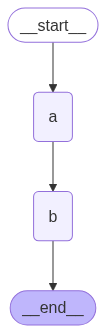

In [31]:
from typing import Annotated


class ChatState(TypedDict, total=False):
    messages: Annotated[  # tells LG how to reduce the field
        list,
        reducer
        ]  

def branch_a(state: ChatState) -> dict:
    return {"messages": {"role": "system", "content": "branch A did work"}}  # No list!

def branch_b(state: ChatState) -> dict:
    return {"messages": {"role": "system", "content": "branch B did work"}}

g4 = StateGraph(ChatState) 
g4.add_node("a", branch_a)
g4.add_node("b", branch_b)

g4.set_entry_point("a") 
g4.add_edge("a", "b") 
g4.add_edge("b", END)


app4 = g4.compile()
out4 = app4.invoke({})

# B Overwrites messages
print("4) merged messages:", [m["content"] for m in out4["messages"]])
app4

# Conversation History

We can use the reduce strategy pattern to implement a convesation history in the graph

In practice, this is the most notable usage 

first pass  
`AIMessage("I am a helpfull assistant`  
second pass  
`HumanMessage("Tell me a joke about devops")`   

In [23]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage


add_messages(
    AIMessage("I am a helpfull assistant"), HumanMessage("Tell me a joke about devops")
)

[AIMessage(content='I am a helpfull assistant', additional_kwargs={}, response_metadata={}, id='c1d07db0-df84-480c-8038-21592aaa49a7'),
 HumanMessage(content='Tell me a joke about devops', additional_kwargs={}, response_metadata={}, id='482e2f12-0e4b-4e00-9a9b-9b0e38249928')]

In [32]:
class State(TypedDict, total=False):
    messages: Annotated[list[AnyMessage], add_messages]  
    msg_len: int  # no reducer strategy: What will happen?

def node_a(state: State):
    new_message = AIMessage("Hello!")
    return {"messages": new_message, "msg_len": len(new_message.content)}

def node_b(state: State):
    new_message = AIMessage("World!")
    return {"messages": new_message, "msg_len": len(new_message.content)}

g5 = StateGraph(State)
g5.add_node(node_a)
g5.add_node(node_b)
g5.set_entry_point("node_a")
g5.add_edge("node_a", "node_b") 
app5 = g5.compile()
out5 = app5.invoke(
    {"messages": {"role": "system", "content": "You are a helpful assitant"}}  # Messages are automatically parsed with role key
    )

for message in out5["messages"]:
    message.pretty_print()

================================ System Message ================================

You are a helpful assitant
================================== Ai Message ==================================

Hello!
================================== Ai Message ==================================

World!


In [33]:
out5["msg_len"]

6